<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords, reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, warnings, zipfile, nltk, re, os
import time
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
warnings.filterwarnings('ignore')

Повнозв'язані нейронні мережі

## Generate Data

In [ ]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

100%|██████████| 1.17M/1.17M [00:00<00:00, 51.0MB/s]

Extracting files...


In [ ]:
numerical_features = ['customers_affected']
categorical_features = ['company_size_cat', 'region_cat', 'customer_tier_cat']

le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium'] - 3 класи
num_classes = len(priorities)

preprocessor = ColumnTransformer(
    transformers=[
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)

X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

if hasattr(X_scaled, "toarray"):
    X_scaled = X_scaled.toarray()

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")

# 1. Розділення на тренувальну та тестову вибірку
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. Перетворення цільової змінної у категоріальний вигляд (one-hot для виходу мережі)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# 3. Побудова нейронної мережі
model = Sequential([
    # input_shape береться автоматично з кількості колонок у вашому X_train
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    # Вихідний шар: кількість нейронів = кількості класів 3
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовому наборі: {test_accuracy:.4f}")

Матриця X_scaled успішно створена. Розмірність: (50000, 10)
Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6329 - loss: 0.7804 - val_accuracy: 0.6789 - val_loss: 0.6810
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6769 - loss: 0.6950 - val_accuracy: 0.6790 - val_loss: 0.6693
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6849 - loss: 0.6756 - val_accuracy: 0.6835 - val_loss: 0.6599
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6848 - loss: 0.6759 - val_accuracy: 0.6829 - val_loss: 0.6676
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6848 - loss: 0.6626 - val_accuracy: 0.6801 - val_loss: 0.6586
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6870 - loss: 0.6612 - val_accuracy: 0.6855 - val_loss: 0.6506
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6872 - loss: 0.6592 - val_accuracy: 0.6812 - val_loss: 0.6605
Epoch 8/100
2000/2000 

In [ ]:
print(f"Точність моделі на тестовій вибірці: {test_accuracy:.4f}")
print("Детальний звіт класифікації:")
print(classification_report(y_test, y_pred))


Точність моделі на тестовій вибірці: 0.6886
Детальний звіт класифікації:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5033
           1       0.57      0.52      0.54      3495
           2       0.69      0.49      0.57      1472

    accuracy                           0.69     10000
   macro avg       0.67      0.62      0.64     10000
weighted avg       0.68      0.69      0.68     10000



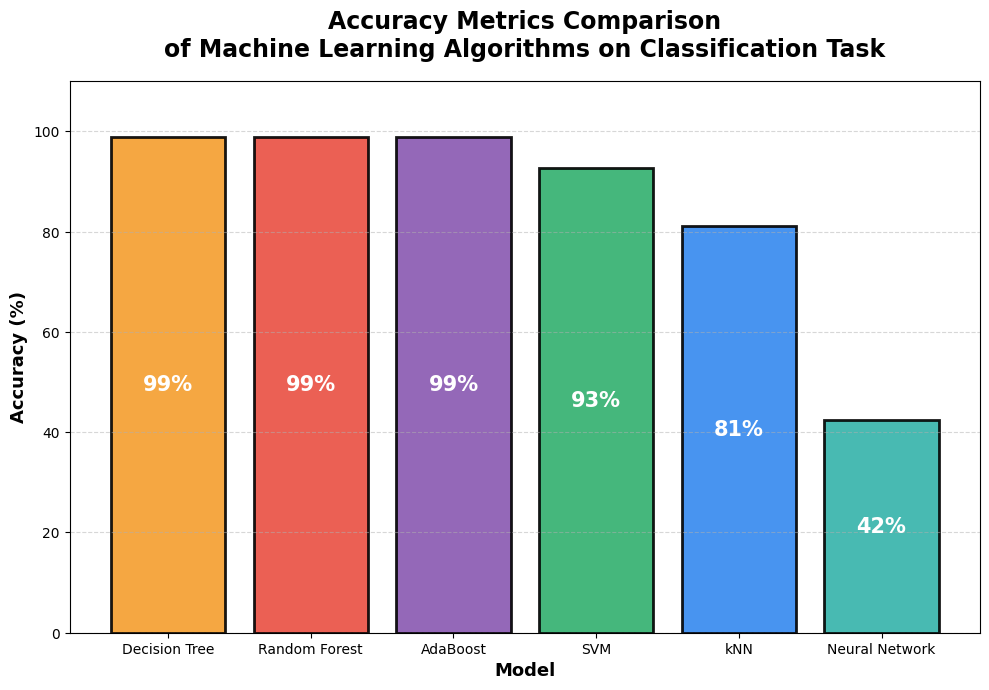

In [ ]:
all_results = {
    'kNN': 0.8111,
    'Decision Tree': 0.9889,
    'SVM': 0.9278,
    'Random Forest': 0.9889,
    'AdaBoost': 0.9889,
    'Neural Network': test_accuracy,
}

sorted_items = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
labels = [x[0] for x in sorted_items]
values = [x[1] for x in sorted_items]

color_map = {
    'kNN': '#3489ef',
    'Decision Tree': '#f49e2d',
    'SVM': '#31af6e',
    'Random Forest': '#e94f41',
    'AdaBoost': '#8857b1',
    'Neural Network': '#34b3aa',
}
bar_colors = [color_map[x] for x in labels]
plt.figure(figsize=(10, 7))
bars = plt.bar(labels, [v*100 for v in values], color=bar_colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.0f}%",
        ha='center', va='center',
        color='white',
        fontsize=15,
        fontweight='bold'
    )

plt.title('Accuracy Metrics Comparison\nof Machine Learning Algorithms on Classification Task', fontsize=17, fontweight='bold', y=1.03)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**# Згорткові нейронні мережі**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/kvasir-dataset")

100%|██████████| 1.15G/1.15G [00:20<00:00, 60.3MB/s]

Extracting files...


In [26]:
import os
import pathlib
path = kagglehub.dataset_download("meetnagadia/kvasir-dataset")
kvasir_root_dir = pathlib.Path(path) / 'kvasir-dataset' / 'Kvasir-Dataset-V2'
data_dir = str(kvasir_root_dir)
if not os.path.isdir(data_dir):
    data_dir = str(pathlib.Path(path) / 'kvasir-dataset')

classes = os.listdir(data_dir)
classes = [c for c in classes if os.path.isdir(os.path.join(data_dir, c))]

print(f"Класів знайдено: {len(classes)}")

valid_extensions = ('.png', '.jpg', '.jpeg')
print(f"Кількість зображень кожного із класів датасету:\n")
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith(valid_extensions)])
    print(f"{cls}: {count} зображень")
print()

Using Colab cache for faster access to the 'kvasir-dataset' dataset.
Класів знайдено: 8
Кількість зображень кожного із класів датасету:

dyed-lifted-polyps: 500 зображень
normal-z-line: 500 зображень
dyed-resection-margins: 500 зображень
normal-pylorus: 500 зображень
normal-cecum: 500 зображень
polyps: 500 зображень
ulcerative-colitis: 500 зображень
esophagitis: 500 зображень



In [27]:
# --- 2. ПІДГОТОВКА ДАНИХ ДЛЯ МОДЕЛІ ---
img_height = 128
img_width = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

print("\nЗавантаження тренувальної вибірки:")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

print("Завантаження валідаційної вибірки:")
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

print(f"\nТренувальних зображень: {train_generator.samples}")
print(f"Валідаційних зображень: {validation_generator.samples}")


Завантаження тренувальної вибірки:
Found 3200 images belonging to 8 classes.
Завантаження валідаційної вибірки:
Found 800 images belonging to 8 classes.

Тренувальних зображень: 3200
Валідаційних зображень: 800


In [29]:
# CNN
model_simple = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_simple = model_simple.evaluate(validation_generator, verbose=0)[1]
print(f"Точність CNN: {test_accuracy_simple:.4f} ({test_accuracy_simple*100:.2f}%)")

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.2985 - loss: 4.7833 - val_accuracy: 0.1250 - val_loss: 20.2243 - learning_rate: 0.0010
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.3811 - loss: 1.4453 - val_accuracy: 0.2463 - val_loss: 3.0390 - learning_rate: 0.0010
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.4326 - loss: 1.3039 - val_accuracy: 0.3212 - val_loss: 1.6794 - learning_rate: 0.0010
Точність CNN: 0.3187 (31.87%)


# **Transfer learning **

In [30]:
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model_transfer = Model(inputs, outputs)
model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_transfer = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність Transfer Learning: {test_accuracy_transfer:.4f} ({test_accuracy_transfer*100:.2f}%)")

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history_finetune = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_finetune = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність після Fine-tuning: {test_accuracy_finetune:.4f} ({test_accuracy_finetune*100:.2f}%)")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.1256 - loss: 2.3834 - val_accuracy: 0.0850 - val_loss: 2.0799 - learning_rate: 1.0000e-04
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 999ms/step - accuracy: 0.1220 - loss: 2.1338 - val_accuracy: 0.1412 - val_loss: 2.0764 - learning_rate: 1.0000e-04
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1274 - loss: 2.0902 - val_accuracy: 0.1300 - val_loss: 2.0706 - learning_rate: 1.0000e-04
Точність Transfer Learning: 0.1300 (13.00%)
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1677 - loss: 2.1781 - val_accuracy: 0.1250 - val_loss: 2.0978 - learning_rate: 1.0000e-05
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2910 - loss: 1.8203 - val_accuracy: 0.1250 - val_loss: 2.1277 - learning_rate: 1.0000e-05
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3792 - loss: 1.6394 - val_accuracy: 0.1250 - val_loss: 2.1

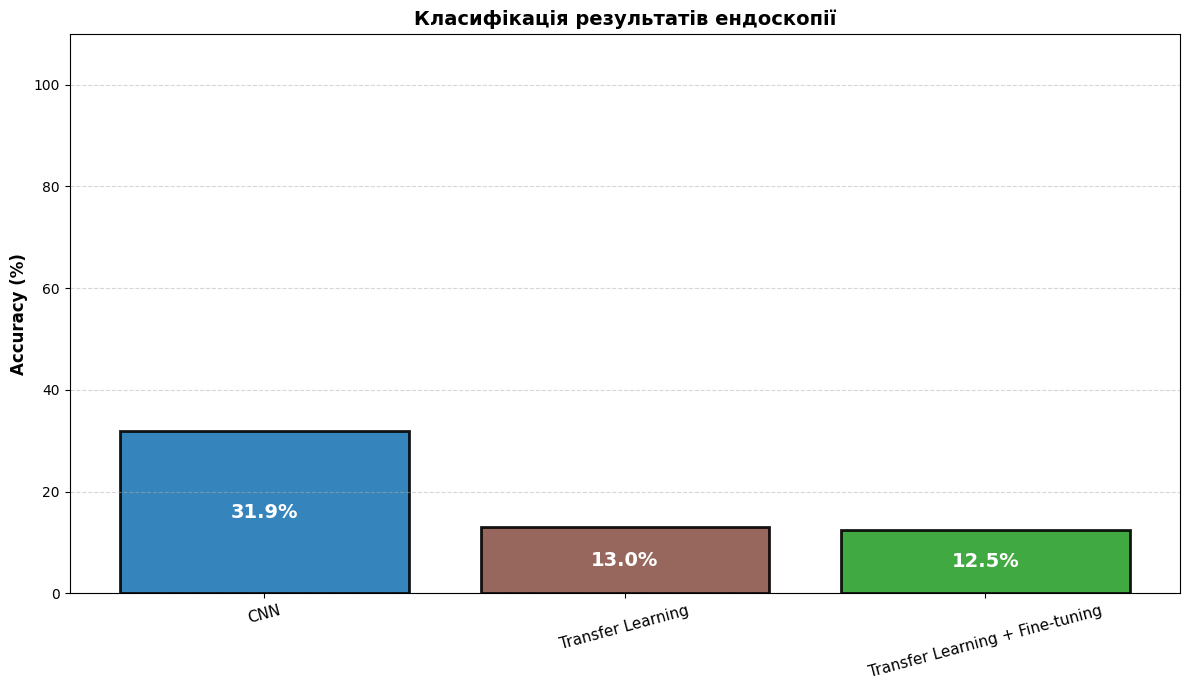

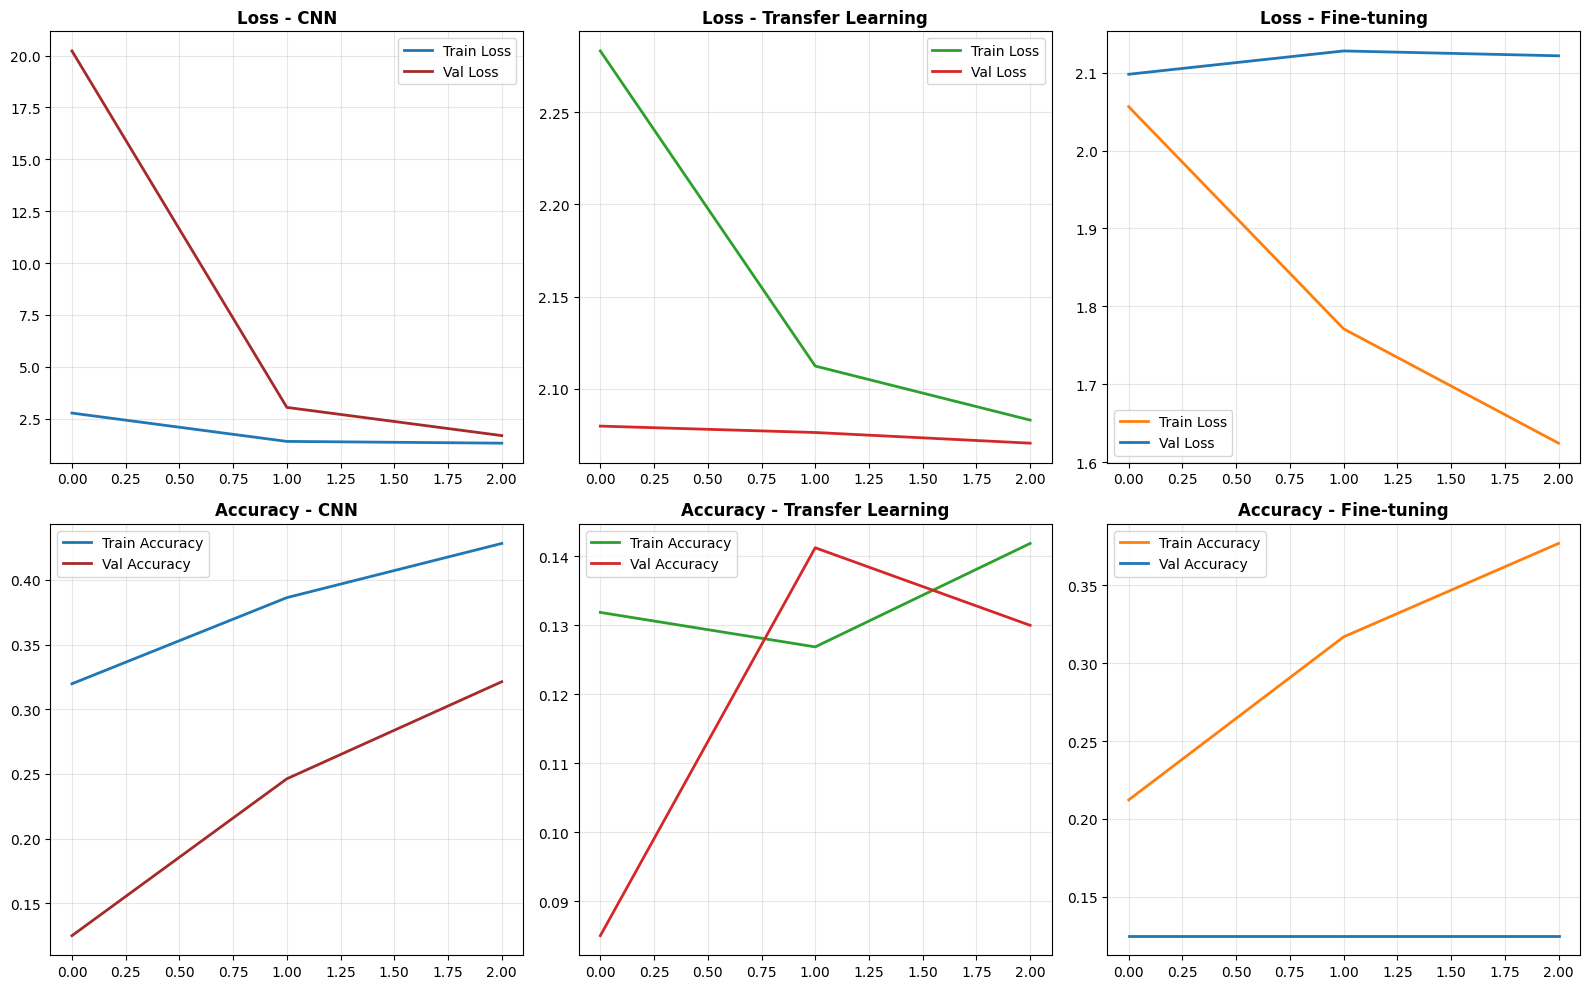

In [31]:
# Візуалізація результатів
comparison_results = {
    'CNN': test_accuracy_simple,
    'Transfer Learning': test_accuracy_transfer,
    'Transfer Learning + Fine-tuning': test_accuracy_finetune,
}

plt.figure(figsize=(12, 7))
sorted_results = dict(sorted(comparison_results.items(), key=lambda x: x[1], reverse=True))
colors = ['#1f77b4', '#8c564b', '#2ca02c']
bars = plt.bar(range(len(sorted_results)), [v*100 for v in sorted_results.values()],
               color=colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, sorted_results.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.1f}%",
        ha='center', va='center',
        color='white', fontsize=14, fontweight='bold'
    )

plt.xticks(range(len(sorted_results)), sorted_results.keys(), fontsize=11, rotation=15)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Класифікація результатів ендоскопії', fontsize=14, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# CNN
axes[0, 0].plot(history_simple.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_simple.history['val_loss'], label='Val Loss', linewidth=2, color='brown')
axes[0, 0].set_title('Loss - CNN', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history_simple.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1, 0].plot(history_simple.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='brown')
axes[1, 0].set_title('Accuracy - CNN', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transfer Learning
axes[0, 1].plot(history_transfer.history['loss'], label='Train Loss', linewidth=2, color='#2ca02c')
axes[0, 1].plot(history_transfer.history['val_loss'], label='Val Loss', linewidth=2, color='#d62728')
axes[0, 1].set_title('Loss - Transfer Learning', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history_transfer.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2ca02c')
axes[1, 1].plot(history_transfer.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#d62728')
axes[1, 1].set_title('Accuracy - Transfer Learning', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Fine-tuning
axes[0, 2].plot(history_finetune.history['loss'], label='Train Loss', linewidth=2, color='#ff7f0e')
axes[0, 2].plot(history_finetune.history['val_loss'], label='Val Loss', linewidth=2, color='#1f77b4')
axes[0, 2].set_title('Loss - Fine-tuning', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2, color='#ff7f0e')
axes[1, 2].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#1f77b4')
axes[1, 2].set_title('Accuracy - Fine-tuning', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# **Задача класифікації текстів**

In [ ]:
FILE_NAME = "first_10000.txt"
all_entries = []

print("Початок ручної обробки файлу...")

# 1. Читання та обробка
try:
    with open(FILE_NAME, 'r', encoding='utf-8', errors='ignore') as f:
        current_entry = {}

        for line in f:
            line = line.strip()
            if not line:
                if current_entry:
                    all_entries.append(current_entry)
                current_entry = {}
                continue

            colonPos = line.find(':')
            if colonPos != -1:
                eName = line[:colonPos].strip()
                rest = line[colonPos+1:].strip()
                current_entry[eName] = rest

            if 'product/productId' in current_entry and len(current_entry) == 1:
                pass

        if current_entry:
            all_entries.append(current_entry)


filtered_entries = [
    e for e in all_entries
    if 'review/score' in e and 'review/text' in e
]

df = pd.DataFrame(filtered_entries)

print(f"\n✅ Кількість знайдених оглядів (ручний парсинг): {df.shape[0]}")

if df.shape[0] > 0:
    # 3.1 Функція визначення тональності
    def get_sentiment(score):
        score = float(score)
        if score >= 4.0:
            return 'positive'
        elif score == 3.0:
            return 'neutral'
        else:
            return 'negative'

    # 3.2 Створення df_text (використовуємо агресивне перейменування/очищення)
    df.columns = df.columns.str.strip()
    df.rename(columns={'review/text': 'text', 'review/score': 'score'}, inplace=True)
    df['sentiment'] = df['score'].apply(get_sentiment)
    df_text = pd.DataFrame({
        'text': df['text'].astype(str),
        'category': df['sentiment']
    })

    print("\n✅ df_text готовий до обробки!")

Початок ручної обробки файлу...

✅ Кількість знайдених оглядів (ручний парсинг): 909

✅ df_text готовий до обробки!


In [ ]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    words = [word for word in text.split() if word not in STOPWORDS and len(word) > 2]
    return " ".join(words)

df_text['cleaned'] = df_text['text'].apply(clean_text)
df_text = df_text[df_text['cleaned'].str.len() > 10].reset_index(drop=True)
texts = df_text['cleaned'].values
label_to_int = {label: i for i, label in enumerate(df_text['category'].unique())}
y_int = df_text['category'].apply(lambda x: label_to_int[x]).values
num_classes = len(label_to_int)

NUM_WORDS = 8000
MAX_LEN = 150
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_one_hot = to_categorical(y_int, num_classes=num_classes)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_pad,
    y_one_hot,
    test_size=0.2,
    random_state=42,
    stratify=y_int
)

# **Random Embedding + Bidirectional LSTM**

In [ ]:

# --- 1. Побудова LSTM-Моделі (БАГАТОКЛАСОВА) ---
model_lstm = Sequential([
    Embedding(NUM_WORDS, 100, input_length=MAX_LEN),
    Bidirectional(LSTM(64, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# 2. Компіляція
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# 3. Навчання
print("\n--- ПОЧАТОК НАВЧАННЯ LSTM ---")

history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop, reduce_lr]
)

# 4. Оцінка
Y_pred_proba = model_lstm.predict(X_test)
Y_pred = tf.argmax(Y_pred_proba, axis=1)
Y_true = tf.argmax(Y_test, axis=1)
acc_lstm = accuracy_score(Y_true, Y_pred)

# 5. Виведення результатів
print(f"\nФінальна точність LSTM: {acc_lstm:.4f}")
target_names = list(df_text['category'].unique())
print("\nЗвіт класифікації:")
print(classification_report(Y_true, Y_pred, target_names=target_names))


--- ПОЧАТОК НАВЧАННЯ LSTM ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.6274 - loss: 0.9537 - val_accuracy: 0.7473 - val_loss: 0.7271 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.7444 - loss: 0.7021 - val_accuracy: 0.7473 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - accuracy: 0.7780 - loss: 0.5596 - val_accuracy: 0.7857 - val_loss: 0.5994 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8787 - loss: 0.3408 - val_accuracy: 0.7692 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.8918 - loss: 0.2270 - val_accuracy: 0.7967 - val_loss: 0.7887 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9045 - loss: 0.1874 - val_accuracy: 0.7198 - val_loss: 0.8357 - learning_rate: 5.0000e-04
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/ste

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

Фінальна точність LSTM: 0.7857

Звіт класифікації:
              precision    recall  f1-score   support

    positive       0.83      0.94      0.88       136
    negative       0.56      0.50      0.53        30
     neutral       0.00      0.00      0.00        16

    accuracy                           0.79       182
   macro avg       0.46      0.48      0.47       182
weighted avg       0.71      0.79      0.74       182



In [ ]:
random_embedding_accuracy = acc_lstm
print(f"Збережена точність (Random Embedding): {random_embedding_accuracy:.4f}")

Збережена точність (Random Embedding): 0.7857


# **Embedding (GloVe) + Bidirectional LSTM**

In [ ]:
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_zip = 'glove6b.zip'
glove_dir = 'glove_embeddings/'
glove_file = 'glove.6B.100d.txt'

# 1. Завантаження та розпакування GloVe
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir, exist_ok=True)

if not os.path.exists(os.path.join(glove_dir, glove_file)):
    print("Завантаження GloVe (6B, 100d)...")
    try:
        r = requests.get(glove_url, stream=True)
        with open(glove_zip, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
            zip_ref.extractall(glove_dir)
        os.remove(glove_zip)


# 2. Створення словника embedding_index
embedding_index = {}
with open(os.path.join(glove_dir, glove_file), 'r', encoding='utf-8') as f:
    for line in f:
         values = line.split()
         word = values[0]
         coefs = np.asarray(values[1:], dtype='float32')
         embedding_index[word] = coefs

# 3. Створення матриці Embedding
embedding_dim = 100
embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# --- 2. ПОБУДОВА МОДЕЛІ (GloVe) ---
model_glove = Sequential([
    Embedding(NUM_WORDS, embedding_dim, input_length=MAX_LEN, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# 3. Компіляція
model_glove.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001), # Трохи вища LR, оскільки базовий шар заморожений
    metrics=['accuracy']
)
early_stop2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# 4. Навчання
print("\n--- ЕТАП 3Б: GLOVE EMBEDDING + LSTM ---")

history_glove = model_glove.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop2, reduce_lr2]
)

# 5. Оцінка
Y_pred_proba_glove = model_glove.predict(X_test)
Y_pred_glove = tf.argmax(Y_pred_proba_glove, axis=1)
Y_true_glove = tf.argmax(Y_test, axis=1)
acc_glove = accuracy_score(Y_true_glove, Y_pred_glove)

# 6. Виведення результатів та Порівняння
target_names = list(df_text['category'].unique())
print(f"\nТочність Embedding (GloVe): {acc_glove:.4f}")
print("\nЗвіт класифікації (GloVe):")
print(classification_report(Y_true_glove, Y_pred_glove, target_names=target_names))


--- ЕТАП 3Б: GLOVE EMBEDDING + LSTM ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.7049 - loss: 0.8270 - val_accuracy: 0.7473 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.7442 - loss: 0.7431 - val_accuracy: 0.7473 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.7642 - loss: 0.6624 - val_accuracy: 0.7527 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7454 - loss: 0.6578 - val_accuracy: 0.7637 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7718 - loss: 0.6040 - val_accuracy: 0.7747 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7840 - loss: 0.5814 - val_accuracy: 0.7692 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms

Точність Random Embedding: 0.786
Точність GloVe Embedding:  0.764



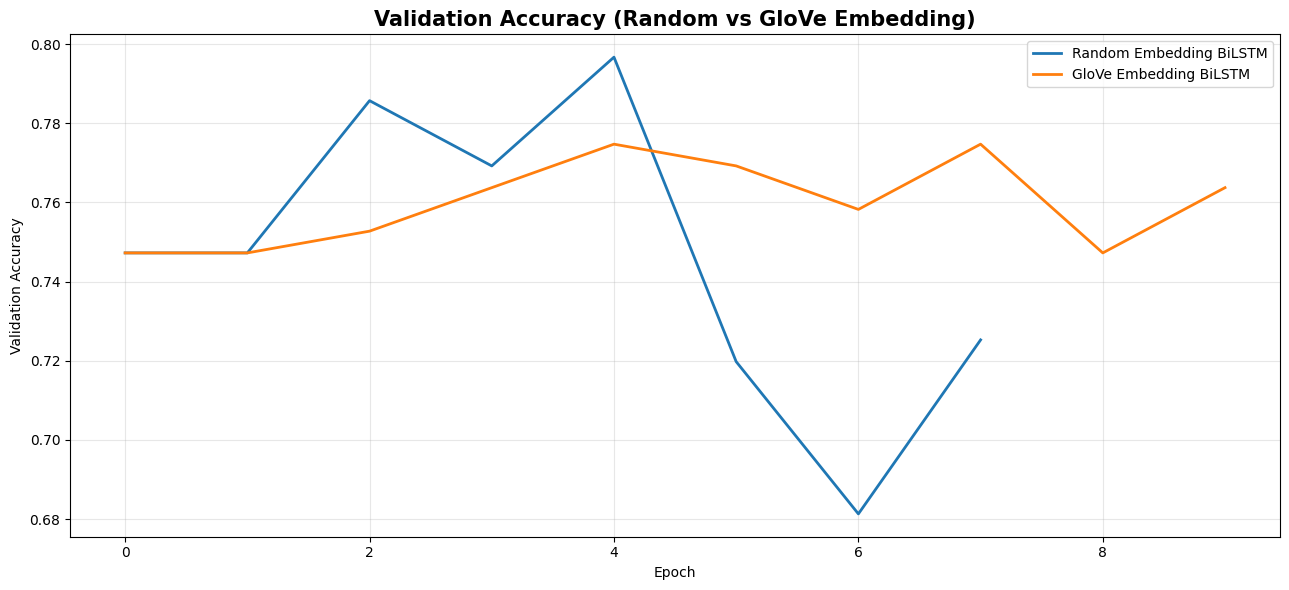

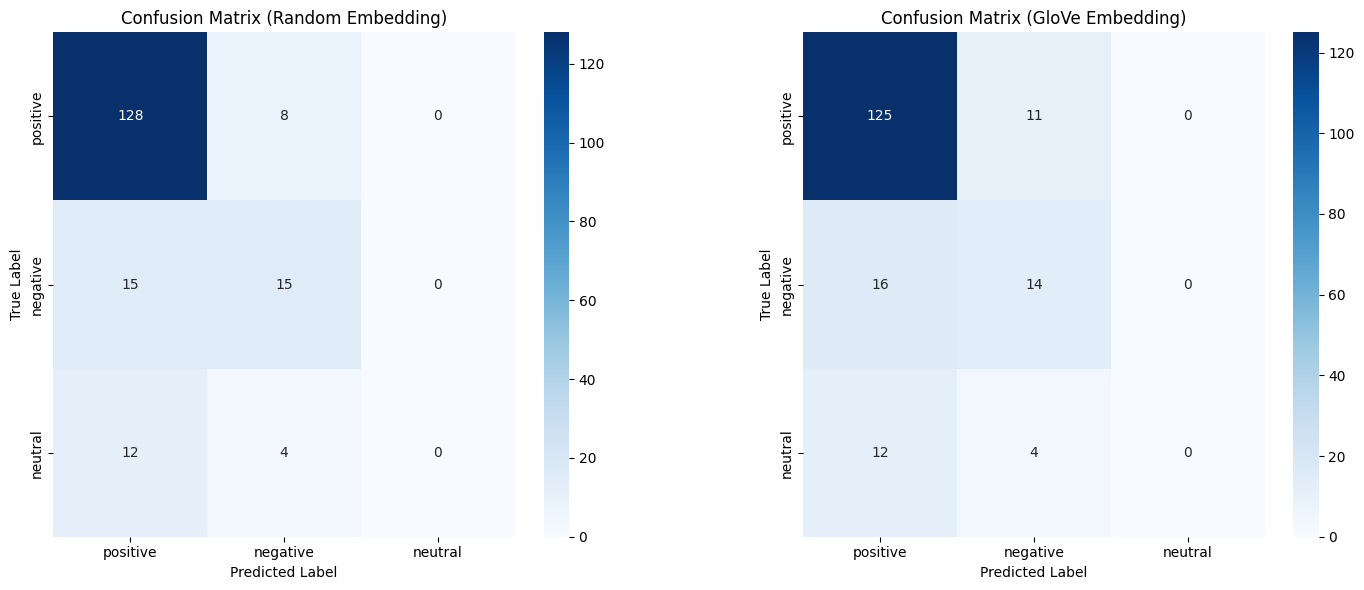

In [ ]:
print(f"Точність Random Embedding: {random_embedding_accuracy:.3f}")
print(f"Точність GloVe Embedding:  {acc_glove:.3f}\n")

# --- 1. ПОРІВНЯННЯ КРИВИХ НАВЧАННЯ ---

plt.figure(figsize=(13,6))
plt.plot(history_lstm.history['val_accuracy'], label='Random Embedding BiLSTM', linewidth=2)
plt.plot(history_glove.history['val_accuracy'], label='GloVe Embedding BiLSTM', linewidth=2)
plt.title('Validation Accuracy (Random vs GloVe Embedding)', fontsize=15, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. МАТРИЦІ ПЛУТАНИНИ ---
target_names = df_text['category'].unique()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Модель Random Embedding (3а)
cm1 = confusion_matrix(Y_true, Y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Random Embedding)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')


# Модель GloVe Embedding (3б)
cm2 = confusion_matrix(Y_true, Y_pred_glove)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            ax=axes[1])
axes[1].set_title(f'Confusion Matrix (GloVe Embedding)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')


plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()